In [1]:
import torch
from torch import nn
import torch.nn.functional as F
import collections
from torch.utils import data
import os
import zipfile
import tarfile
import hashlib
import requests
import math
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
import time

## 模型
---

## 基于位置的前馈网络
---

In [2]:
class PositionWiseFFN(nn.Module):
    """基于位置的前馈网络"""
    def __init__(self, ffn_num_input, ffn_num_hiddens, ffn_num_outputs, **kwargs):
        super(PositionWiseFFN, self).__init__(**kwargs)
        self.dense1 = nn.Linear(ffn_num_input, ffn_num_hiddens)
        self.relu = nn.ReLU()
        self.dense2 = nn.Linear(ffn_num_hiddens, ffn_num_outputs)
    
    def forward(self, X):
        return self.dense2(self.relu(self.dense1(X)))

In [3]:
ffn = PositionWiseFFN(4, 4, 8)
ffn.eval()
ffn(torch.ones(2,3,4)).shape

torch.Size([2, 3, 8])

## 残差连接和层规范化
---

In [4]:
ln = nn.LayerNorm(2)
bn = nn.BatchNorm1d(2)
X = torch.tensor([[1,2],[2,3], [3,4]], dtype=torch.float32)
print('Layer Norm:\n\t', ln(X), '\nBatch Norm:\n\t', bn(X))

Layer Norm:
	 tensor([[-1.0000,  1.0000],
        [-1.0000,  1.0000],
        [-1.0000,  1.0000]], grad_fn=<NativeLayerNormBackward0>) 
Batch Norm:
	 tensor([[-1.2247e+00, -1.2247e+00],
        [ 0.0000e+00,  1.1921e-07],
        [ 1.2247e+00,  1.2247e+00]], grad_fn=<NativeBatchNormBackward0>)


In [5]:
"""knowhow --- torch.nn中LN和BN的参数
nn.LayerNorm是PyTorch中用于实现层归一化(Layer Normalization)的类, 类声明如下: 
    class torch.nn.LayerNorm(normalized_shape, eps=1e-05, elementwise_affine=True)
    -- normalized_shape: 一个整数或整数元组,指定输入张量的形状。例如,如果输入张量的形状是 (batch_size, num_features),
                        则normalized_shape应为 num_features。
    -- eps: 一个小的浮点数,用于数值稳定性
    -- elementwise_affine:一个布尔值, 指定是否应用可学习的仿射变换。如果为True,则会为每个归一化维度添加可学习的仿射变换

nn.BatchNorm1D是PyTorch中用于实现一维批归一化(Batch Normalization)的类, 类声明如下: 
    class torch.nn.BatchNorm1d(num_features, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    -- num_features:一个整数,指定输入张量的特征维度
    -- eps:一个小的浮点数,用于数值稳定性
    -- momentum:一个浮点数,用于计算运行平均值和方差的动量
    -- affine:一个布尔值,指定是否应用可学习的仿射变换。如果为True,则会为每个特征维度添加可学习的仿射变换
    -- track_running_stats:一个布尔值,指定是否应该跟踪运行时的统计信息(平均值和方差)。如果为True,则在训练过程
                            中会计算并跟踪这些统计信息,以便在推理时使用
"""

'knowhow --- torch.nn中LN和BN的参数\nnn.LayerNorm是PyTorch中用于实现层归一化(Layer Normalization)的类, 类声明如下: \n    class torch.nn.LayerNorm(normalized_shape, eps=1e-05, elementwise_affine=True)\n    -- normalized_shape: 一个整数或整数元组,指定输入张量的形状。例如,如果输入张量的形状是 (batch_size, num_features),\n                        则normalized_shape应为 num_features。\n    -- eps: 一个小的浮点数,用于数值稳定性\n    -- elementwise_affine:一个布尔值, 指定是否应用可学习的仿射变换。如果为True,则会为每个归一化维度添加可学习的仿射变换\n\nnn.BatchNorm1D是PyTorch中用于实现一维批归一化(Batch Normalization)的类, 类声明如下: \n    class torch.nn.BatchNorm1d(num_features, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)\n    -- num_features:一个整数,指定输入张量的特征维度\n    -- eps:一个小的浮点数,用于数值稳定性\n    -- momentum:一个浮点数,用于计算运行平均值和方差的动量\n    -- affine:一个布尔值,指定是否应用可学习的仿射变换。如果为True,则会为每个特征维度添加可学习的仿射变换\n    -- track_running_stats:一个布尔值,指定是否应该跟踪运行时的统计信息(平均值和方差)。如果为True,则在训练过程\n                            中会计算并跟踪这些统计信息,以便在推理时使用\n'

In [6]:
class AddNorm(nn.Module):
    """残差连接后进行层规范化"""
    def __init__(self, normalized_shape, dropout, **kwargs):
        super(AddNorm, self).__init__(**kwargs)
        self.dropout = nn.Dropout(dropout)
        self.ln = nn.LayerNorm(normalized_shape)
    
    def forward(self, X, Y):
        return self.ln(self.dropout(Y)+X)

In [7]:
add_norm = AddNorm([3,4], 0.5)
add_norm.eval()
add_norm(torch.ones((2,3,4)), torch.ones((2,3,4))).shape

torch.Size([2, 3, 4])

## 编码器
---

In [8]:
def sequence_mask(X, valid_len, value=0):
    """在序列中遮蔽不相关的项"""
    maxlen = X.size(1)
    mask = torch.arange((maxlen), dtype=torch.float32, device=X.device)[None,:] < valid_len[:, None]
    X[~mask] = value
    return X

In [9]:
def masked_softmax(X, valid_lens):
    """通过在最后一个轴上掩蔽元素来执行softmax操作"""
    ## X: 3D张量 valid_lens: 1D或2D张量
    if valid_lens is None:
        return F.softmax(X, dim=-1)
    shape = X.shape
    if valid_lens.dim() == 1:
        valid_lens = torch.repeat_interleave(valid_lens, shape[1])
    else:
        valid_lens = valid_lens.reshape(-1)
    X = sequence_mask(X.reshape(-1, shape[-1]), valid_lens, value=-1e6)
    return F.softmax(X.reshape(shape), dim=-1)

In [10]:
class DotProductAttention(nn.Module):
    """缩放点积注意力"""
    def __init__(self, dropout, **kwargs):
        super(DotProductAttention, self).__init__(**kwargs)
        self.dropout = nn.Dropout(dropout)
    def forward(self, queries, keys, values, valid_lens=None):
        ## queries的形状: (batch_size, 查询个数, d)
        ## keys的形状: (batch_size, 键值对个数, d)
        ## values的形状: (batch_size, 键值对个数, 值的维度)
        ## valid_lens的形状: (batch_size,)或(batch_size, 查询个数)
        d = queries.shape[-1]
        scores = torch.bmm(queries, keys.transpose(1,2))/math.sqrt(d)
        self.attention_weights = masked_softmax(scores, valid_lens)
        return torch.bmm(self.dropout(self.attention_weights), values)

In [11]:
## 输入X形状: (batch_size, 查询或键值对个数, num_hiddens)
def transpose_qkv(X, num_heads):
    """为了多注意力头的并行计算而变换形状"""
    X = X.reshape(X.shape[0], X.shape[1], num_heads, -1)    ## (batch_size, 查询或键值对个数, num_heads, num_hiddens/num_heads)
    X = X.permute(0, 2, 1, 3) ## (batch_size, num_heads, 查询或键值对个数, num_hiddens/num_heads)
    return X.reshape(-1, X.shape[2], X.shape[3]) ## (batch_size*num_heads, 查询或键值对个数, num_hiddens/num_heads)

def transpose_output(X, num_heads):
    """逆转transpose_qkv函数的操作"""
    X = X.reshape(-1, num_heads, X.shape[1], X.shape[2])
    X = X.permute(0, 2, 1, 3)
    return X.reshape(X.shape[0], X.shape[1], -1)

In [12]:
class MultiHeadAttention(nn.Module):
    def __init__(self, key_size, query_size, value_size, num_hiddens,
                 num_heads, dropout, bias=False, **kwargs):
        super(MultiHeadAttention, self).__init__(**kwargs)
        self.num_heads = num_heads
        self.attention = DotProductAttention(dropout)
        self.W_q = nn.Linear(query_size, num_hiddens, bias=bias)
        self.W_k = nn.Linear(key_size, num_hiddens, bias=bias)
        self.W_v = nn.Linear(value_size, num_hiddens, bias=bias)
        self.W_o = nn.Linear(num_hiddens, num_hiddens, bias=bias)
    
    ## queries, keys, values的形状: (batch_size, 查询或键值对数, num_hiddens)
    ## valid_lens的形状: (batch_size,)或(batch_size, 查询的个数)
    def forward(self, queries, keys, values, valid_lens):
        queries = transpose_qkv(self.W_q(queries), self.num_heads)
        keys = transpose_qkv(self.W_k(keys), self.num_heads)
        values = transpose_qkv(self.W_v(values), self.num_heads)

        if valid_lens is not None:
            valid_lens = torch.repeat_interleave(
                valid_lens, repeats=self.num_heads, dim=0
            )
        output = self.attention(queries, keys, values, valid_lens)  ## (batch_size*num_heads, 查询个数, num_hiddens/num_heads)
        output_concat = transpose_output(output, self.num_heads)
        return self.W_o(output_concat)

In [13]:
class EncoderBlock(nn.Module):
    def __init__(self, key_size, query_size, value_size, num_hiddens,
                 norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
                 dropout, use_bias=False, **kwargs):
        super(EncoderBlock, self).__init__(**kwargs)
        self.attention = MultiHeadAttention(
            key_size, query_size, value_size, num_hiddens, 
            num_heads, dropout, use_bias
        )
        self.addnorm1 = AddNorm(norm_shape, dropout)
        self.ffn = PositionWiseFFN(
            ffn_num_input, ffn_num_hiddens, num_hiddens
        )
        self.addnorm2 = AddNorm(norm_shape, dropout)

    def forward(self, X, valid_lens):
        Y = self.addnorm1(X, self.attention(X, X, X, valid_lens))
        return self.addnorm2(Y, self.ffn(Y))

In [14]:
X = torch.ones((2, 100, 24))
valid_lens = torch.tensor([3,2])
encoder_blk = EncoderBlock(24, 24, 24, 24, [100, 24], 24, 48, 8, 0.5)
encoder_blk.eval()
encoder_blk(X, valid_lens).shape

torch.Size([2, 100, 24])

In [15]:
class Encoder(nn.Module):
    """编码器-解码器架构的基本编码器接口"""
    def __init__(self, **kwargs):
        super(Encoder, self).__init__(**kwargs)
    def forward(self, X, *args):
        raise NotImplementedError

In [16]:
class PositionalEncoding(nn.Module):
    """位置编码"""
    def __init__(self, num_hiddens, dropout, max_len=1000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(dropout)
        self.P = torch.zeros((1, max_len, num_hiddens))
        X = torch.arange(max_len, dtype=torch.float32).reshape(-1,1)/\
        torch.pow(10000, torch.arange(0, num_hiddens, 2, dtype=torch.float32)/num_hiddens)
        self.P[:,:,0::2] = torch.sin(X)
        self.P[:,:,1::2] = torch.cos(X)
    def forward(self, X):
        X += self.P[:,:X.shape[1],:].to(X.device)
        return self.dropout(X)


In [17]:
class TransformerEncoder(Encoder):
    """Transformer编码器"""
    def __init__(self, vocab_size, key_size, query_size, value_size,
                 num_hiddens, norm_shape, ffn_num_input, ffn_num_hiddens, 
                 num_heads, num_layers, dropout, use_bias=False, **kwargs):
        super(TransformerEncoder, self).__init__(**kwargs)
        self.num_hiddens = num_hiddens
        self.embedding = nn.Embedding(vocab_size, num_hiddens)
        self.pos_encoding = PositionalEncoding(num_hiddens, dropout)
        self.blks = nn.Sequential()
        for i in range(num_layers):
            self.blks.add_module(
                'block'+str(i),
                EncoderBlock(
                    key_size, query_size, value_size, num_hiddens,
                    norm_shape, ffn_num_input, ffn_num_hiddens, num_heads, 
                    dropout, use_bias
                )
            ) 
    
    def forward(self, X, valid_lens, *args):
        ## 因为位置编码在-1和1之间,因此嵌入值乘以嵌入维度的平方根进行缩放然后再与位置编码相加
        X = self.pos_encoding(self.embedding(X)*math.sqrt(self.num_hiddens))
        self.attention_weights = [None]*len(self.blks)
        for i, blk in enumerate(self.blks):
            X = blk(X, valid_lens)
            self.attention_weights[i] = blk.attention.attention.attention_weights
        return X

In [18]:
encoder = TransformerEncoder(
    200, 24, 24, 24, 24, [100, 24], 24, 48, 8, 2, 0.5
)
encoder.eval()
encoder(torch.ones((2,100), dtype=torch.long), valid_lens).shape

torch.Size([2, 100, 24])

## 解码器
---

In [19]:
class DecoderBlock(nn.Module):
    """解码器中第i个块"""
    def __init__(self, key_size, query_size, value_size, num_hiddens,
                 norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
                 dropout, i, **kwargs):
        super(DecoderBlock, self).__init__(**kwargs)
        self.i = i
        self.attention1 = MultiHeadAttention(
            key_size, query_size, value_size, num_hiddens,
            num_heads, dropout
        )
        self.addnorm1 = AddNorm(norm_shape, dropout)
        self.attention2 = MultiHeadAttention(
            key_size, query_size, value_size, num_hiddens,
            num_heads, dropout
        )
        self.addnorm2 = AddNorm(norm_shape, dropout)
        self.ffn = PositionWiseFFN(ffn_num_input, ffn_num_hiddens, num_hiddens)
        self.addnorm3 = AddNorm(norm_shape, dropout)
    
    def forward(self, X, state):
        enc_outputs, enc_valid_lens = state[0], state[1]
        ## 训练阶段,输出序列的所有词元都在同一时间处理, 
        ## 因此state[2][self.i]初始化为None
        ## 预测阶段,输出序列是通过一个一个词元解码的,因此
        ## state[2][self.i]包含着直到当前时间步第i个块解码的
        ## 输出表示
        if state[2][self.i] is None:
            key_values = X
        else:
            key_values = torch.cat((state[2][self.i], X), axis=1)
        state[2][self.i] = key_values
        if self.training:
            batch_size, num_steps, _ = X.shape
            dec_valid_lens = torch.arange(
                1, num_steps+1, device=X.device 
            ).repeat(batch_size, 1)
        else:
            dec_valid_lens = None
        ## 自注意力
        X2 = self.attention1(X, key_values, key_values, dec_valid_lens)
        Y = self.addnorm1(X, X2)
        ## 编码器-解码器注意力
        ## enc_outputs的开头: (batch_size, num_steps, num_hiddens)
        Y2 = self.attention2(Y, enc_outputs, enc_outputs, enc_valid_lens)
        Z = self.addnorm2(Y, Y2)
        return self.addnorm3(Z, self.ffn(Z)), state

In [20]:
decoder_blk = DecoderBlock(
    24,24,24,24,[100,24],24,48,8,0.5,0
)
X = torch.ones((2,100,24))
state = [encoder_blk(X, valid_lens), valid_lens, [None]]
decoder_blk(X, state)[0].shape

torch.Size([2, 100, 24])

In [21]:
class Decoder(nn.Module):
    def __init__(self, **kwargs):
        super(Decoder, self).__init__(**kwargs)
    def init_state(self, enc_outputs, *args):
        raise NotImplementedError
    def forward(self, X, state):
        raise NotImplementedError

In [22]:
class AttentionDecoder(Decoder):
    """带有注意力机制解码器的基本接口"""
    def __init__(self, **kwargs):
        super(AttentionDecoder, self).__init__()
    
    @property
    def attention_weights(self):
        raise NotImplementedError

In [23]:
class TransformerDecoder(AttentionDecoder):
    def __init__(self, vocab_size, key_size, query_size, value_size,
                 num_hiddens, norm_shape, ffn_num_input, ffn_num_hiddens,
                 num_heads, num_layers, dropout, **kwargs):
        super(TransformerDecoder, self).__init__(**kwargs)
        self.num_hiddens = num_hiddens
        self.num_layers = num_layers
        self.embedding = nn.Embedding(vocab_size, num_hiddens)
        self.pos_encoding = PositionalEncoding(num_hiddens, dropout)
        self.blks = nn.Sequential()
        for i in range(num_layers):
            self.blks.add_module(
                'block' + str(i),
                DecoderBlock(
                    key_size, query_size, value_size, num_hiddens,
                    norm_shape, ffn_num_input, ffn_num_hiddens, 
                    num_heads, dropout, i
                )
            )
        self.dense = nn.Linear(num_hiddens, vocab_size)
    
    def init_state(self, enc_outputs, enc_valid_lens, *args):
        return [enc_outputs, enc_valid_lens, [None]*self.num_layers]

    def forward(self, X, state):
        X = self.pos_encoding(self.embedding(X)*math.sqrt(self.num_hiddens))
        self._attention_weights = [[None]*len(self.blks) for _ in range(2)]
        for i, blk in enumerate(self.blks):
            X, state = blk(X, state)
            ## 解码器自注意力权重
            self._attention_weights[0][i] \
                = blk.attention1.attention.attention_weights
            ## 编码器-解码器自注意力权重
            self._attention_weights[1][i] \
                = blk.attention2.attention.attention_weights
        return self.dense(X), state
        
    @property
    def attention_weights(self):
        return self._attention_weights

## 训练
---

In [24]:
class EncoderDecoder(nn.Module):
    """编码器-解码器的基类"""
    def __init__(self, encoder, decoder, **kwargs):
        super(EncoderDecoder, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
    def forward(self, enc_X, dec_X, *args):
        enc_outputs = self.encoder(enc_X, *args)
        dec_state = self.decoder.init_state(enc_outputs, *args)
        return self.decoder(dec_X, dec_state)

In [25]:
DATA_HUB = dict()
DATA_URL = 'http://d2l-data.s3-accelerate.amazonaws.com/'

In [26]:
def download_dataset(name, cache_dir=None):
    """下载一个DATA_HUB中的文件,返回本地文件名"""
    assert name in DATA_HUB, f"{name} not in {DATA_HUB}"
    cache_dir = os.path.join('..', 'data') if cache_dir is None else cache_dir
    url, sha1_hash = DATA_HUB[name]
    os.makedirs(cache_dir, exist_ok=True)
    fname = os.path.join(cache_dir, url.split('/')[-1])
    if os.path.exists(fname):
        sha1 = hashlib.sha1()
        with open(fname, 'rb') as f:
            while True:
                data = f.read(1048576)
                if not data:
                    break
                sha1.update(data)
            if sha1.hexdigest() == sha1_hash:
                return fname
    print(f"Downloading {name} from {url} to {fname}...")
    raw_data = requests.get(url, stream=True, verify=True)
    with open(fname, 'wb') as f:
        f.write(raw_data.content)
    return fname


In [27]:
def download_dataset_and_extract(name, folder=None):
    """下载并解压zip/tar文件"""
    fname = download_dataset(name)
    base_dir = os.path.dirname(fname)
    data_dir, ext = os.path.splitext(fname)
    match ext:
        case '.zip':
            fp = zipfile.ZipFile(fname, 'r')
        case '.tar', '.gz':
            fp = tarfile.open(fname, 'r')
        case _:
            assert False, f'不支持的文件类型：{ext}'
    fp.extractall(path=base_dir)
    fp.close()
    return os.path.join(base_dir, folder) if folder else data_dir

def download_all_datasets():
    """下载DATA_HUB中的所有数据集"""
    for name in DATA_HUB:
        download_dataset(name)
    

In [28]:
DATA_HUB['fra-eng'] = (DATA_URL + 'fra-eng.zip',
                       '94646ad1522d915e7b0f9296181140edcf86a4f5')

In [29]:
def read_data_nmt():
    """载入'英语-法语'数据集"""
    data_dir = download_dataset_and_extract('fra-eng')
    with open(os.path.join(data_dir, 'fra.txt'), 'r', encoding='utf-8') as f:
        return f.read()

In [30]:
def preprocess_nmt(text):
    """预处理'英语-法语'数据集"""
    def no_space(char, prev_char):
        return char in set(',.!?') and prev_char != ' '
    ## 使用空格替换不间断空格，使用小写字母替换大写字母
    text = text.replace('\u202f', ' ').replace('\xa0', ' ').lower()
    ## 在单词和标点符号之间插入空格
    out = [' ' + char if i > 0 and no_space(char, text[i-1]) else char for i, char in enumerate(text)]
    return ''.join(out)

In [31]:
def tokenize_nmt(text, num_examples=None):
    """词元化'英语-法语'数据数据集"""
    source, target = [], []
    for i, line in enumerate(text.split('\n')):
        if num_examples and i > num_examples:
            break
        parts = line.split('\t')
        if len(parts) == 2:
            source.append(parts[0].split(' '))
            target.append(parts[1].split(' '))
    return source, target

In [32]:
class Vocab:
    """文本词表"""
    def __init__(self, tokens=None, min_freq=0, reserved_tokens=None):
        tokens = [] if tokens is None else tokens
        reserved_tokens = [] if reserved_tokens is None else reserved_tokens
        ## 按出现频率排序
        counter = Vocab.count_corpus(tokens)
        self._token_freqs = sorted(counter.items(), key=lambda x: x[1], reverse=True)
        self.idx2token = ['<unk>'] + reserved_tokens
        self.token2idx = {token: idx for idx, token in enumerate(self.idx2token)}
        for token, freq in self._token_freqs:
            if freq < min_freq:
                break
            if token not in self.token2idx:
                self.idx2token.append(token)
                self.token2idx[token] = len(self.idx2token)-1
    def __len__(self):
        return len(self.idx2token)
    def __getitem__(self, tokens):
        if not isinstance(tokens, (list, tuple)):
            return self.token2idx.get(tokens, self.unk)
        return [self.__getitem__(token) for token in tokens]
    def to_tokens(self, indices):
        if not isinstance(indices, (list, tuple)):
            return self.idx2token[indices]
        return [self.idx2token[index] for index in indices]
    @property
    def unk(self):
        return 0
    @property
    def token_freqs(self):
        return self._token_freqs 
    @staticmethod
    def count_corpus(tokens):
        """统计词元频率"""
        if isinstance(tokens[0], list):
            tokens = [token for line in tokens for token in line]
        return collections.Counter(tokens)
  

In [33]:
def truncate_pad(line, num_steps, padding_token):
    """截断或填充文本序列"""
    if len(line) > num_steps:
        return line[:num_steps]
    return line + [padding_token]*(num_steps-len(line))

In [34]:
def build_array_nmt(lines, vocab, num_steps):
    """将机器翻译的文本序列转换成小批量"""
    lines = [vocab[l] for l in lines]
    lines = [l + [vocab['<eos>']] for l in lines]
    array = torch.tensor(
        [truncate_pad(l, num_steps, vocab['<pad>']) for l in lines]
    )
    valid_len = (array != vocab['<pad>']).type(torch.int32).sum(1)
    return array, valid_len

In [35]:
def load_array(data_arrays, batch_size, is_train=True):
    """构造一个PyTorch数据迭代器"""
    dataset = data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset, batch_size=batch_size, shuffle=is_train)

In [36]:
def load_data_nmt(batch_size, num_steps, num_examples=600):
    """返回翻译数据集的迭代器和词表"""
    text = preprocess_nmt(read_data_nmt())
    source, target = tokenize_nmt(text, num_examples)
    src_vocab = Vocab(source, min_freq=2, reserved_tokens=['<pad>', '<bos>', '<eos>'])
    tgt_vocab = Vocab(target, min_freq=2, reserved_tokens=['<pad>', '<bos>', '<eos>'])
    src_array, src_valid_len = build_array_nmt(source, src_vocab, num_steps)
    tgt_array, tgt_valid_len = build_array_nmt(target, tgt_vocab, num_steps)
    data_arrays = (src_array, src_valid_len, tgt_array, tgt_valid_len)
    data_iter = load_array(data_arrays, batch_size=batch_size)
    return data_iter, src_vocab, tgt_vocab

In [37]:
class Timer:
    """记录多次运行时间"""
    def __init__(self):
        self.times = []
        self.start()
    def start(self):
        """启动计时器"""
        self.tik = time.time()
    def stop(self):
        """停止计时器并将时间记录在列表中"""
        self.times.append(time.time() - self.tik)
        return self.times[-1]
    def avg(self):
        """返回平均时间"""
        return sum(self.times) / len(self.times)
    def sum(self):
        """返回时间总和"""
        return sum(self.times)
    def cumsum(self):
        """返回累计时间"""
        return np.cumsum(self.times).tolist()

In [38]:
class Accumulator:
    def __init__(self, n):
        self.data = [.0] * n
    def add(self, *args):
        self.data = [a+float(b) for a, b in zip(self.data, args)]
    def reset(self):
        self.data = [.0] * len(self.data)
    def __getitem__(self, i):
        return self.data[i]

In [39]:
class Animator:
    """在动画中绘制数据"""
    def __init__(self, xlabel=None, ylabel=None, xlim=None, ylim=None,
                xscale='linear', yscale='linear', legend=None,
                fmts=('-', 'm--', 'g-.', 'r:')):
        ## 增量地绘制多条线
        legend = [] if legend is None else legend
        self.fig, self.axes = plt.gcf(), plt.gca()
        self.config_axes = lambda: self.set_axes(xlabel, ylabel, xlim, ylim, xscale, yscale, legend) ## 使用lambda表达式捕获变量
        self.X, self.Y, self.fmts = None, None, fmts

    def set_axes(self, xlabel, ylabel, xlim, ylim, xscale, yscale, legend):
        self.axes.set_xlabel(xlabel)
        self.axes.set_ylabel(ylabel)
        self.axes.set_xlim(xlim)
        self.axes.set_ylim(ylim)
        self.axes.set_xscale(xscale)
        self.axes.set_yscale(yscale)
        self.axes.legend(legend)
        self.axes.grid()

    def add(self, x, y):
        """向图表中添加多个数据点"""
        y = [y] if not hasattr(y, "__len__") else y
        x = [x] * len(y) if not hasattr(x, "__len__") else x
        self.X = [[] for _ in range(len(y))] if self.X is None else self.X
        self.Y = [[] for _ in range(len(y))] if self.Y is None else self.Y
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes.cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes.plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

In [40]:
def grad_clipping(net, theta):
    """裁剪梯度"""
    params = [p for p in net.parameters() if p.requires_grad]
    norm = torch.sqrt(sum(torch.sum(p.grad**2) for p in params))
    if norm > theta:
        for param in params:
            param.grad *= theta/norm

In [41]:
class MaskedSoftmaxCELoss(nn.CrossEntropyLoss):
    """带遮蔽的softmax交叉熵损失函数"""
    ## pred      --> (batch_size, num_steps, vocab_size)
    ## label     --> (batch_size, num_steps)
    ## valid_len --> (batch_size, )
    def forward(self, pred, label, valid_len):
        weights = torch.ones_like(label)
        weights = sequence_mask(weights, valid_len)
        self.reduction = 'none'
        unweighted_loss = super(MaskedSoftmaxCELoss, self).forward(
            pred.permute(0, 2, 1), label
        )
        weighted_loss = (unweighted_loss * weights).mean(dim=1)
        return weighted_loss


In [42]:
def train(net, data_iter, lr, num_epochs, tgt_vocab, device):
    """训练序列到序列模型"""
    def xavier_init_weights(m):
        match type(m):
            case nn.Linear:
                nn.init.xavier_normal_(m.weight)
            case nn.GRU:
                for param in m._flat_weights_names:
                    if 'weight' in param:
                        nn.init.xavier_normal_(m._parameters[param])
            case _:
                pass
    net.apply(xavier_init_weights)
    net.to(device)
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    loss = MaskedSoftmaxCELoss()
    net.train()
    animator = Animator(xlabel='epoch', ylabel='loss', xlim=[10, num_epochs])
    for epoch in range(num_epochs):
        timer = Timer()
        metric = Accumulator(2)  ## 训练损失总和,词元数量
        for batch in data_iter:
            optimizer.zero_grad()
            X, X_valid_len, Y, Y_valid_len = [x.to(device) for x in batch]
            bos = torch.tensor([tgt_vocab['<bos>']]*Y.shape[0], device=device).reshape(-1, 1)
            dec_input = torch.cat([bos, Y[:, :-1]], 1)
            Y_hat, _ = net(X, dec_input, X_valid_len)
            l = loss(Y_hat, Y, Y_valid_len)
            l.sum().backward()
            grad_clipping(net, 1)
            num_tokens = Y_valid_len.sum()
            optimizer.step()
            with torch.no_grad():
                metric.add(l.sum(), num_tokens)
        if (epoch+1) % 10 == 0:
            animator.add(epoch+1, (metric[0]/metric[1],))
    print(f'loss {metric[0]/metric[1]:.3f}, {metric[1]/timer.stop():.1f} '
          f'tokens/sec on {str(device)}')


loss 0.031, 2584.2 tokens/sec on cpu


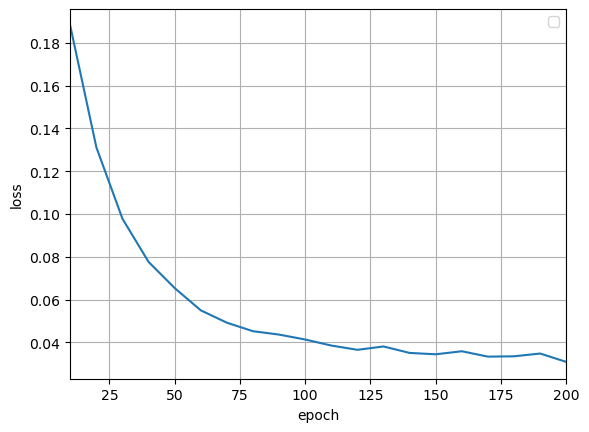

In [43]:
num_hiddens, num_layers, dropout, batch_size, num_steps = 32, 2, 0.1, 64, 10
lr, num_epochs, device = 0.005, 200, torch.device('cpu')
ffn_num_input, ffn_num_hiddens, num_heads = 32, 64, 4
key_size, query_size, value_size = 32, 32, 32
norm_shape = [32]

train_iter, src_vocab, tgt_vocab = load_data_nmt(batch_size, num_steps)
encoder = TransformerEncoder(
    len(src_vocab), key_size, query_size, value_size, num_hiddens,
    norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
    num_layers, dropout
)
decoder = TransformerDecoder(
    len(tgt_vocab), key_size, query_size, value_size, num_hiddens,
    norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
    num_layers, dropout
)
net = EncoderDecoder(encoder, decoder)
train(net, train_iter, lr, num_epochs, tgt_vocab, device)

In [44]:
def predict(net, src_sentence, src_vocab, tgt_vocab, num_steps, device, save_attention_weights=False):
    """序列到序列模型的预测"""
    ## 在预测时把net置为评估模式
    net.eval()
    src_tokens = src_vocab[src_sentence.lower().split(' ')]+[src_vocab['<eos>']]
    enc_valid_len = torch.tensor([len(src_tokens)], device=device)
    src_tokens = truncate_pad(src_tokens, num_steps, src_vocab['<pad>'])
    ## 添加批量维度
    enc_X = torch.unsqueeze(
        torch.tensor(src_tokens, dtype=torch.long, device=device), 
        dim=0
    )
    enc_outputs = net.encoder(enc_X, enc_valid_len)
    dec_state = net.decoder.init_state(enc_outputs, enc_valid_len)
    ## 添加批量维度
    dec_X = torch.unsqueeze(
        torch.tensor([tgt_vocab['<bos>']], dtype=torch.long, device=device),
        dim = 0
    )
    output_seq, attention_weight_seq = [], []
    for _ in range(num_steps):
        Y, dec_state = net.decoder(dec_X, dec_state)
        dec_X = Y.argmax(dim=2)
        pred = dec_X.squeeze(dim=0).type(torch.int32).item()
        if save_attention_weights:
            attention_weight_seq.append(net.decoder.attention_weights)
        if pred == tgt_vocab['<eos>']:
            break
        output_seq.append(pred)
    return ' '.join(tgt_vocab.to_tokens(output_seq)), attention_weight_seq

In [45]:
def bleu(pred_seq, label_seq, k):
    """计算bleu"""
    pred_tokens, label_tokens = pred_seq.split(' '), label_seq.split(' ')
    len_pred, len_label = len(pred_tokens), len(label_tokens)
    score = math.exp(min(0, 1-len_label/len_pred))
    for n in range(1, k+1):
        num_matches, label_subs = 0, collections.defaultdict(int)
        for i in range(len_label-n+1):
            label_subs[' '.join(label_tokens[i:i+n])] += 1
        for i in range(len_pred-n+1):
            if label_subs[' '.join(pred_tokens[i:i+n])] > 0:
                num_matches += 1
                label_subs[' '.join(pred_tokens[i:i+n])] -= 1
        score *= math.pow(num_matches / (len_pred-n+1), math.pow(0.5, n))
    return score

In [46]:
engs = ['go .', "i lost .", 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
for eng, fra in zip(engs, fras):
    translation, dec_attention_weight_seq = predict(
        net, eng, src_vocab, tgt_vocab, num_steps, device, True
    )
    print(f'{eng} => {translation}, ',
          f'bleu {bleu(translation, fra, k=2):.3f}')

go . => va !,  bleu 1.000
i lost . => j'ai perdu .,  bleu 1.000
he's calm . => il est calme .,  bleu 1.000
i'm home . => je suis chez moi .,  bleu 1.000


## Exercises
---

1. 在实验中训练更深的Transformer将如何影响训练速度和翻译效果？

2. 在Transformer中使用加性注意力取代缩放点积注意力是不是个好办法？为什么？

3. 对于语言模型，应该使用Transformer的编码器还是解码器，或者两者都用？如何设计？

4. 如果输入序列很长，Transformer会面临什么挑战？为什么？

5. 如何提高Transformer的计算速度和内存使用效率？提示：可以参考论文 (Tay et al., 2020)

6. 如果不使用卷积神经网络，如何设计基于Transformer模型的图像分类任务？提示：可以参考Vision Transformer (Dosovitskiy et al., 2021)